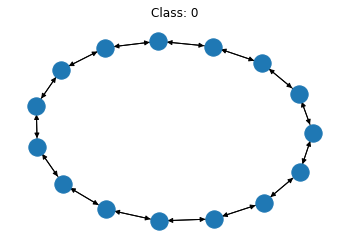

In [5]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [6]:
graph.num_nodes()

15

In [7]:
graph.num_edges()

45

In [8]:
graph.in_degrees()

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [9]:
graph.out_degrees()

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [10]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# The return type of :func:`dgl.batch` is still a graph. In the same way, 
# a batch of tensors is still a tensor. This means that any code that works
# for one graph immediately works for a batch of graphs. More importantly,
# because DGL processes messages on all nodes and edges in parallel, this greatly
# improves efficiency.

In [11]:
from dgl.nn.pytorch import GraphConv

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')     ### Readout Function
        return self.classify(hg)

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)


In [14]:
trainset.graphs[0]

Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={})

In [15]:
# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [16]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0161
Epoch 1, loss 1.9778
Epoch 2, loss 1.9693
Epoch 3, loss 1.9510
Epoch 4, loss 1.9378
Epoch 5, loss 1.9428
Epoch 6, loss 1.9162
Epoch 7, loss 1.8908
Epoch 8, loss 1.8653
Epoch 9, loss 1.8260
Epoch 10, loss 1.7905
Epoch 11, loss 1.7431
Epoch 12, loss 1.6947
Epoch 13, loss 1.6372
Epoch 14, loss 1.5819
Epoch 15, loss 1.5231
Epoch 16, loss 1.4704
Epoch 17, loss 1.4112
Epoch 18, loss 1.3501
Epoch 19, loss 1.2973
Epoch 20, loss 1.2393
Epoch 21, loss 1.2107
Epoch 22, loss 1.1575
Epoch 23, loss 1.1339
Epoch 24, loss 1.0991
Epoch 25, loss 1.0696
Epoch 26, loss 1.0337
Epoch 27, loss 1.0206
Epoch 28, loss 1.0321
Epoch 29, loss 0.9762
Epoch 30, loss 0.9519
Epoch 31, loss 0.9440
Epoch 32, loss 0.9321
Epoch 33, loss 0.9028
Epoch 34, loss 0.8968
Epoch 35, loss 0.8936
Epoch 36, loss 0.8830
Epoch 37, loss 0.9221
Epoch 38, loss 0.8788
Epoch 39, loss 0.8495
Epoch 40, loss 0.8631
Epoch 41, loss 0.8459
Epoch 42, loss 0.8299
Epoch 43, loss 0.8379
Epoch 44, loss 0.8388
Epoch 45, loss 0.848

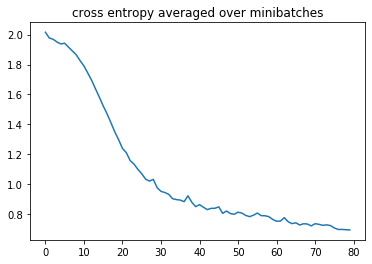

In [17]:
# The learning curve of a run is presented below.

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [18]:
# The trained model is evaluated on the test set created. To deploy
# the tutorial, restrict the running time to get a higher
# accuracy (:math:`80` % ~ :math:`90` %) than the ones printed below.

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 58.7500%
Accuracy of argmax predictions on the test set: 71.250000%


In [19]:
test_bg = dgl.batch(test_X)

In [20]:
probs_Y = torch.softmax(model(test_bg), 1)

In [21]:
prediction = model(bg)

In [22]:
prediction.shape

torch.Size([32, 8])

In [23]:
First_layer_pred = []
for i in range(0,len(trainset)):
    h = trainset.graphs[i].in_degrees().view(-1, 1).float()
    x = F.relu(model.conv1(trainset.graphs[i], h))
    First_layer_pred.append(np.mean(x.detach().numpy(),0))

In [145]:
First_layer_pred[0]

array([0.        , 0.00635034, 0.46580884, 0.        , 0.        ,
       0.        , 0.        , 0.906904  , 0.663962  , 0.6638413 ,
       0.        , 0.        , 0.20090936, 0.        , 0.4599849 ,
       0.        , 0.65087616, 0.23567295, 0.        , 0.        ,
       0.62305766, 0.        , 0.00573289, 0.        , 0.50708526,
       0.        , 0.        , 0.        , 0.21028902, 0.47279823,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.8486909 , 0.        , 0.        , 0.        ,
       0.655961  , 0.00484467, 0.04229152, 0.9618952 , 0.        ,
       0.01206209, 0.06131314, 0.13936044, 0.        , 0.        ,
       0.64867246, 0.0068385 , 0.        , 0.        , 0.01709291,
       0.6725359 , 0.01213597, 0.006284  , 0.05669726, 0.00584662,
       0.        , 0.3655272 , 0.0080488 , 0.00589496, 0.6497811 ,
       0.65544856, 0.        , 0.96731466, 0.        , 0.        ,
       0.09132253, 0.1177019 , 0.71560794, 0.        , 0.00574

In [24]:
First_layer_pred = np.stack(First_layer_pred, axis=0)

In [147]:
type(First_layer_pred)

numpy.ndarray

In [25]:
from sklearn.manifold import TSNE

In [26]:
First_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = First_layer_TSNE.fit_transform(First_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.013s...
[t-SNE] Computed neighbors for 320 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.561058
[t-SNE] KL divergence after 2000 iterations: -0.447843


In [150]:
Y

array([[-1.11080189e+01, -1.45068939e+02],
       [ 7.60516815e+01, -4.67540169e+01],
       [ 1.28123001e+02, -4.94698753e+01],
       [ 1.28373520e+02, -4.30528488e+01],
       [-7.09187698e+00, -1.50395432e+02],
       [ 2.21032357e+00, -1.88908173e+02],
       [ 1.34548325e+02, -4.86320992e+01],
       [-1.51577854e+00, -1.44488739e+02],
       [ 9.72004242e+01, -4.30342941e+01],
       [ 1.24148651e+02, -5.45623245e+01],
       [ 1.62315285e+00, -1.58110352e+02],
       [-6.06417322e+00, -1.57699097e+02],
       [-1.37178984e+01, -1.89851974e+02],
       [-1.13007536e+01, -1.83867340e+02],
       [ 8.61759262e+01, -4.49271622e+01],
       [-6.06417322e+00, -1.57699097e+02],
       [-1.40646827e+00, -1.52289917e+02],
       [-1.26485710e+01, -1.53749344e+02],
       [-7.37272596e+00, -1.89799118e+02],
       [ 8.61759262e+01, -4.49271622e+01],
       [-1.51577854e+00, -1.44488739e+02],
       [ 2.21032357e+00, -1.88908173e+02],
       [-5.16485023e+00, -1.83362244e+02],
       [-1.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [28]:
colors = cm.rainbow(np.linspace(0, 1, max(trainset.labels).detach().numpy()+1)) 

In [29]:
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.17647059e-01, 4.29120609e-01, 9.75511968e-01, 1.00000000e+00],
       [7.25490196e-02, 7.82927610e-01, 9.00586702e-01, 1.00000000e+00],
       [3.54901961e-01, 9.74138602e-01, 7.82927610e-01, 1.00000000e+00],
       [6.45098039e-01, 9.74138602e-01, 6.22112817e-01, 1.00000000e+00],
       [9.27450980e-01, 7.82927610e-01, 4.34676422e-01, 1.00000000e+00],
       [1.00000000e+00, 4.29120609e-01, 2.19946358e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [155]:
max(trainset.labels).detach().numpy()

array(7)

In [30]:
trainset_label_array = trainset.labels.detach().numpy()

In [31]:
label_index = (trainset_label_array == 0)

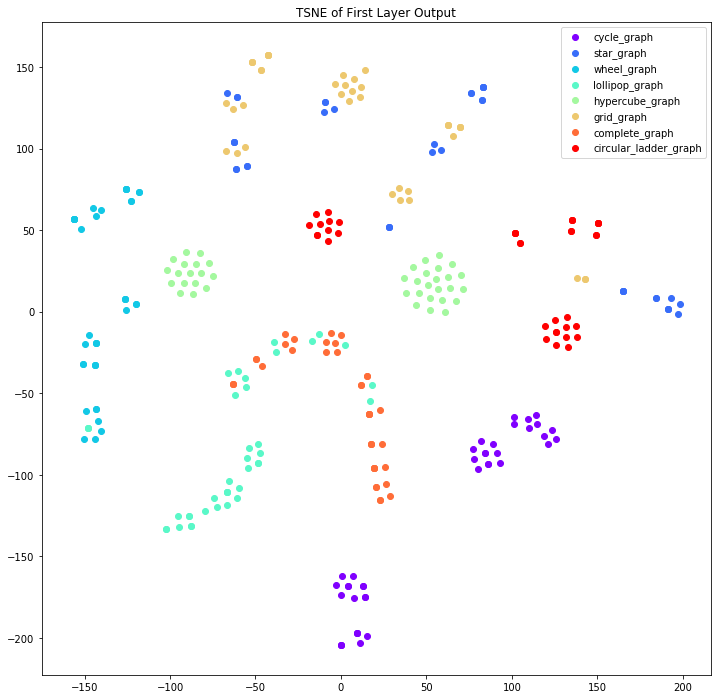

In [32]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of First Layer Output')
plt.show()

In [175]:
Second_layer_pred = []
for i in range(0,len(trainset)):
    h = trainset.graphs[i].in_degrees().view(-1, 1).float()
    h = F.relu(model.conv1(trainset.graphs[i], h))
    x = F.relu(model.conv2(trainset.graphs[i], h))
    Second_layer_pred.append(np.mean(x.detach().numpy(),0))

In [176]:
Second_layer_pred = np.stack(Second_layer_pred, axis=0)

In [193]:
Second_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = Second_layer_TSNE.fit_transform(Second_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.012s...
[t-SNE] Computed neighbors for 320 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.299900
[t-SNE] KL divergence after 2000 iterations: -0.449301


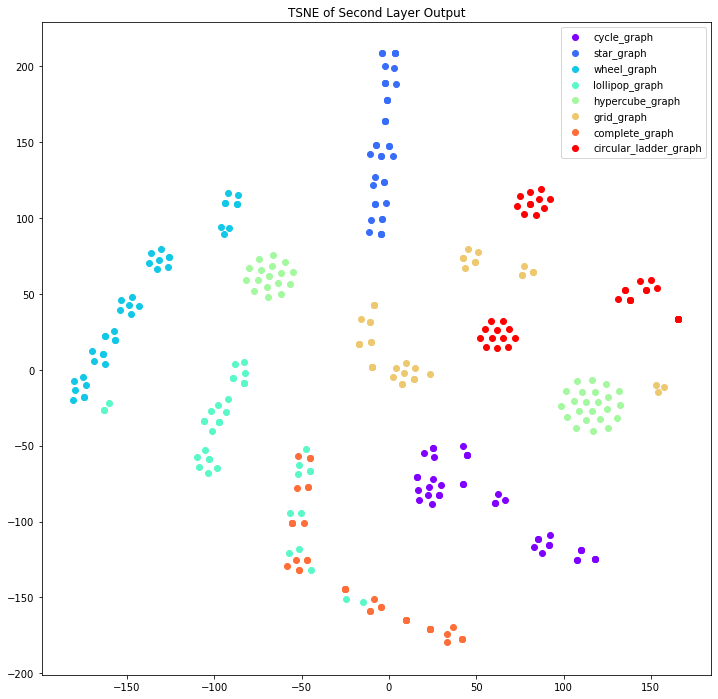

In [194]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of Second Layer Output')
plt.show()

In [191]:
Classify_layer_pred = []
for i in range(0,len(trainset)):
    x = model(trainset.graphs[i])
    Classify_layer_pred.append(np.mean(x.detach().numpy(),0))

In [192]:
Classify_layer_pred = np.stack(Classify_layer_pred, axis=0)

In [195]:
Classify_layer_TSNE = TSNE(2, perplexity = 10, learning_rate=10, verbose=1, n_iter=2000, random_state=2020)
Y = Classify_layer_TSNE.fit_transform(Classify_layer_pred)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 320 samples in 0.001s...
[t-SNE] Computed neighbors for 320 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 320 / 320
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.660587
[t-SNE] KL divergence after 2000 iterations: -0.407421


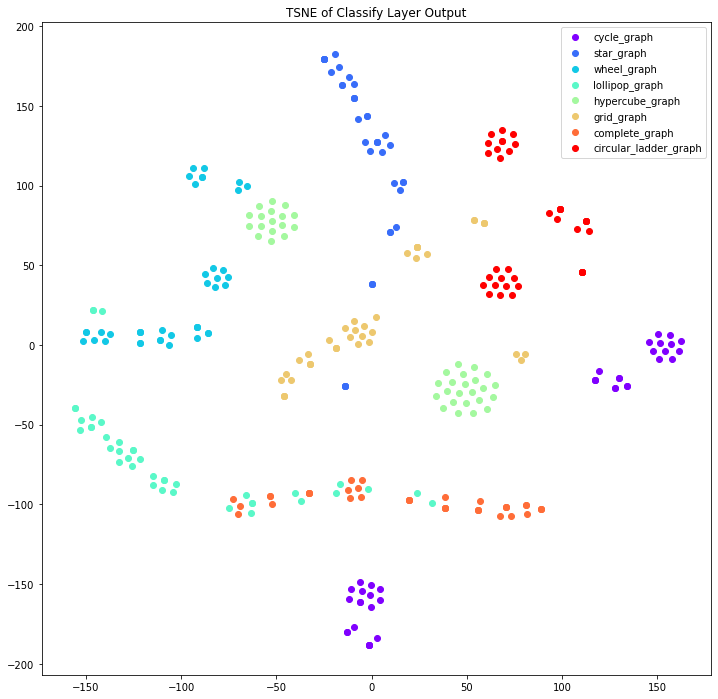

In [196]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()
for i in range(0,max(trainset.labels).detach().numpy()+1):
    label_index = (trainset_label_array == i)
    #color_indx = int(trainset.labels[i].detach().numpy());
    ax.scatter(Y[label_index, 0], Y[label_index, 1],color=colors[i])
#handles, labels = ax.get_legend_handles_labels()
plt.legend(['cycle_graph','star_graph','wheel_graph','lollipop_graph','hypercube_graph','grid_graph','complete_graph','circular_ladder_graph'], loc='best')
plt.title('TSNE of Classify Layer Output')
plt.show()